# 1. Imports

In [7]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### text processing

In [36]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to C:\Users\AYUSH
[nltk_data]     SINGH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### plotting style

In [10]:
plt.rcParams.update({'figure.max_open_warning': 0})


# 2. Paths & load

In [13]:
DATA_PATH = 'dreaddit_StressAnalysis - Sheet1.csv' # update path if needed
OUT_DIR = Path('dreaddit_eda_outputs')
OUT_DIR.mkdir(exist_ok=True)

### read CSV

In [14]:
df = pd.read_csv(DATA_PATH)

In [16]:
print('rows, cols:', df.shape)
print('columns:', df.columns.tolist())

rows, cols: (715, 116)
columns: ['id', 'subreddit', 'post_id', 'sentence_range', 'text', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain

# 3. Select required columns

In [17]:
keep_cols = [c for c in df.columns if (
c == 'text' or c == 'label' or c.startswith('lex_liwc_') or c.startswith('lex_dal_') or c.startswith('syntax_') or c == 'sentiment' or c.startswith('social_')
)]

In [22]:
expected_extra = ['confidence', 'post_id', 'id', 'subreddit', 'social_karma']
for c in expected_extra:
    if c in df.columns and c not in keep_cols:
        keep_cols.append(c)
eda_df = df[keep_cols].copy()

# 4. Basic statistics & saved summary

In [24]:
summary = eda_df.describe(include='all').transpose()
summary.to_csv(OUT_DIR / 'basic_summary.csv')

In [26]:
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
text,715,715,"Its like that, if you want or not.“ ME: I have...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,715.0,NaN,NaN,NaN,0.516084,0.500091,0.0,0.0,1.0,1.0,1.0
social_timestamp,715.0,NaN,NaN,NaN,1517569805.774825,15539436.863658,1483329777.0,1509572176.0,1516657634.0,1531001175.0,1542583224.0
social_karma,715.0,NaN,NaN,NaN,24.627972,113.086473,0.0,2.0,5.0,10.0,1687.0
syntax_ari,715.0,NaN,NaN,NaN,4.705624,3.244652,-4.8,2.584422,4.477286,6.723889,22.535493
...,...,...,...,...,...,...,...,...,...,...,...
sentiment,715.0,NaN,NaN,NaN,0.045345,0.194114,-1.0,-0.056181,0.04246,0.154701,0.8
confidence,715.0,NaN,NaN,NaN,0.717895,0.325688,0.0,0.6,0.8,1.0,1.0
post_id,715,586,8c6fwz,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,715.0,NaN,NaN,NaN,13861.372028,17765.755427,2.0,848.0,1778.0,26201.5,55783.0


In [27]:
class_counts = eda_df['label'].value_counts(dropna=False)
class_counts.to_csv(OUT_DIR / 'label_counts.csv')

In [29]:
class_counts

label
1    369
0    346
Name: count, dtype: int64

# 5. Class balance (Stress vs Non-Stress)

In [30]:
print('\nClass balance:')
print(class_counts)


Class balance:
label
1    369
0    346
Name: count, dtype: int64


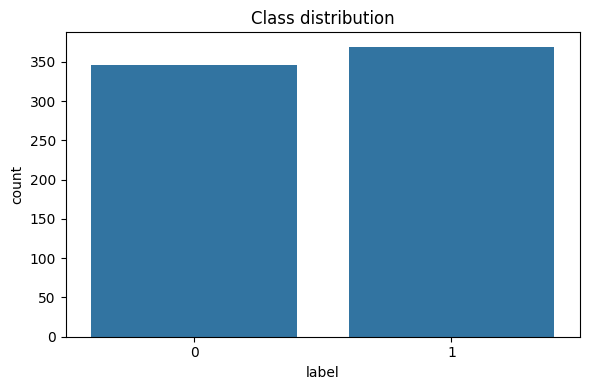

In [33]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class distribution')
plt.xlabel('label')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# 6. Text length analysis (tokens, characters)

In [39]:
# compute token counts and character counts
eda_df['char_len'] = eda_df['text'].astype(str).apply(len)
eda_df['token_list'] = eda_df['text'].astype(str).apply(word_tokenize)
eda_df['token_len'] = eda_df['token_list'].apply(len)
eda_df[['char_len','token_len']].describe()
# summary
eda_df[['char_len','token_len']].describe().to_csv(OUT_DIR/'text_length_summary.csv')

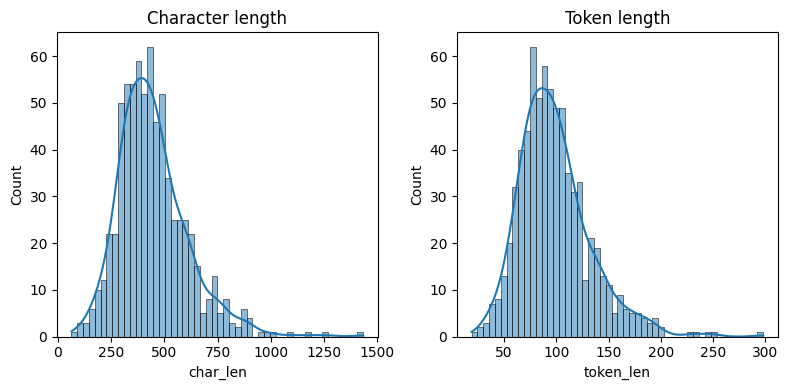

In [41]:
# plots
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(eda_df['char_len'], bins=50, kde=True)
plt.title('Character length')
plt.subplot(1,2,2)
sns.histplot(eda_df['token_len'], bins=50, kde=True)
plt.title('Token length')
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR/'text_length_histograms.png')
plt.close()

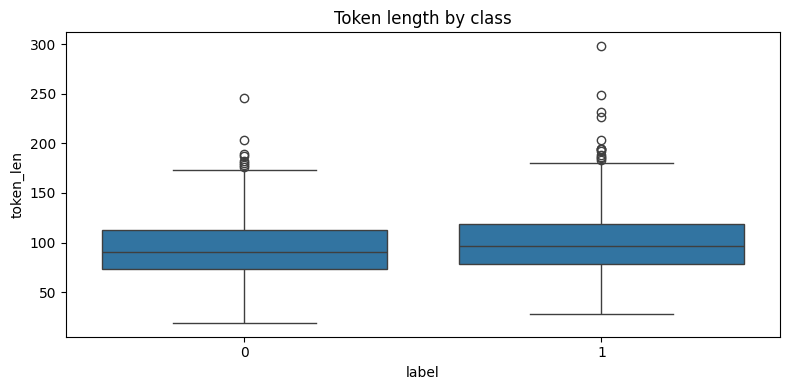

In [44]:
# Boxplot by class
plt.figure(figsize=(8,4))
sns.boxplot(x='label', y='token_len', data=eda_df)
plt.title('Token length by class')
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR/'token_length_by_class.png')
plt.close()


# 7. Distribution of LIWC categories 

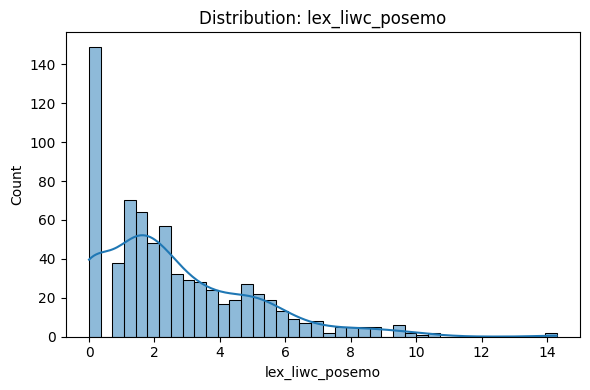

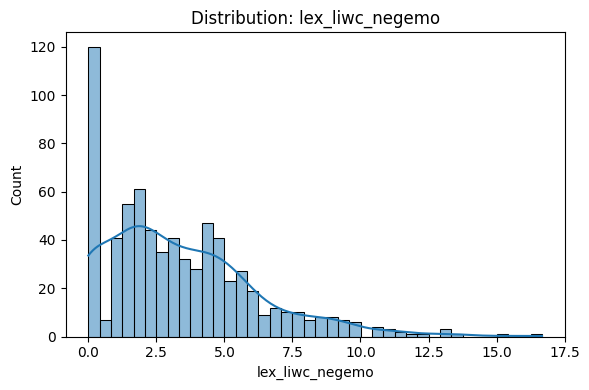

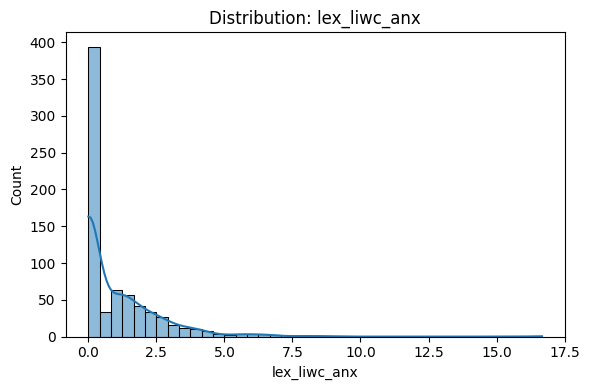

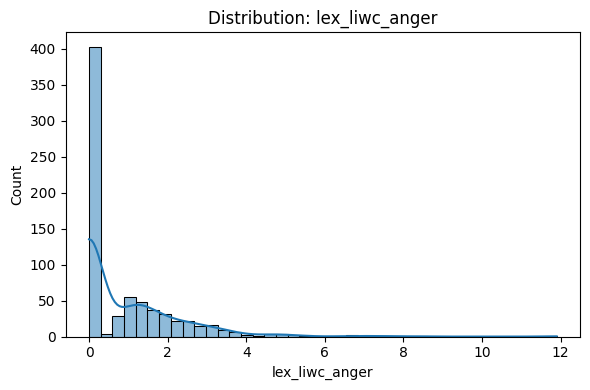

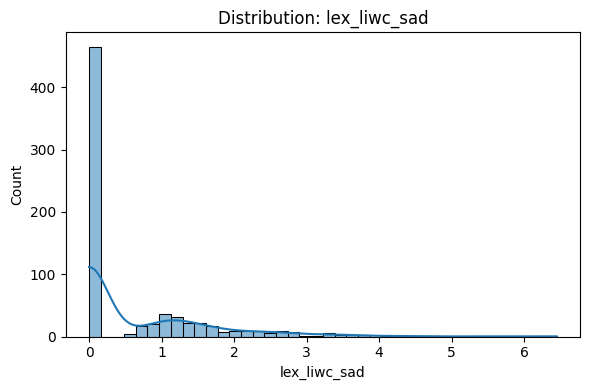

In [46]:
liwc_cols = [c for c in eda_df.columns if c.startswith('lex_liwc_')]
# pick a few common psychological categories if present
interesting = [c for c in ['lex_liwc_posemo','lex_liwc_negemo','lex_liwc_anx','lex_liwc_anger','lex_liwc_sad'] if c in liwc_cols]


for c in interesting:
    plt.figure(figsize=(6,4))
    sns.histplot(eda_df[c].dropna(), bins=40, kde=True)
    plt.title(f'Distribution: {c}')
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_DIR/f'{c}_dist.png')
    plt.close()

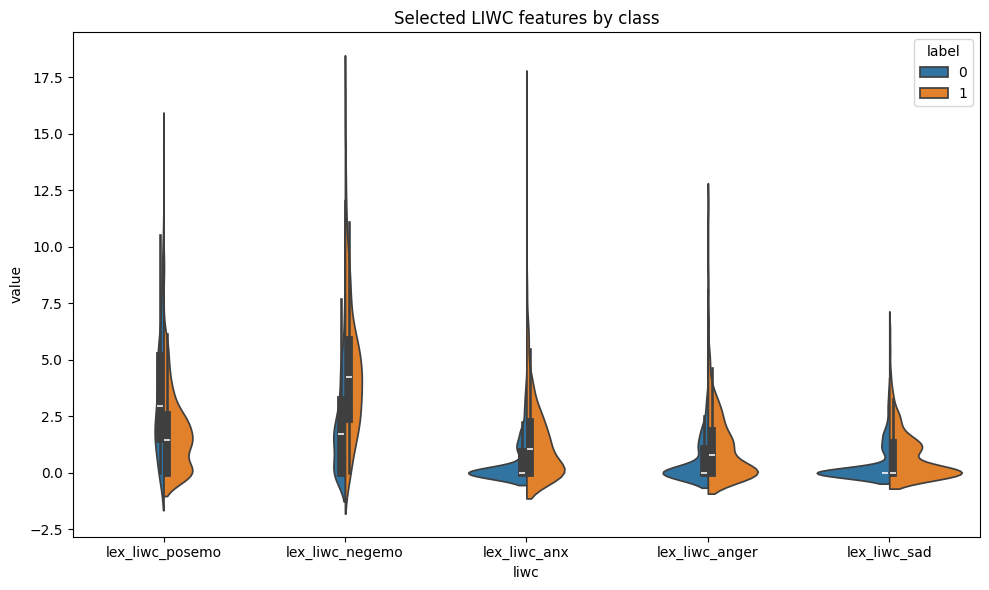

In [47]:
# violin by class for liwc categories
plt.figure(figsize=(10,6))
sub = eda_df.melt(id_vars=['label'], value_vars=interesting, var_name='liwc', value_name='value')
sns.violinplot(x='liwc', y='value', hue='label', data=sub, split=True)
plt.title('Selected LIWC features by class')
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR/'liwc_by_class_violin.png')
plt.close()

# 8. Distribution of DAL features (pleasantness, activation, imagery)

DAL columns found: ['lex_dal_max_pleasantness', 'lex_dal_max_activation', 'lex_dal_max_imagery', 'lex_dal_min_pleasantness', 'lex_dal_min_activation', 'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery', 'lex_dal_avg_pleasantness']


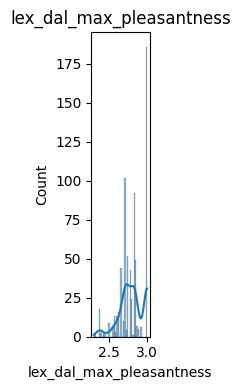

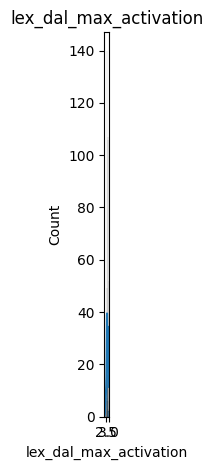

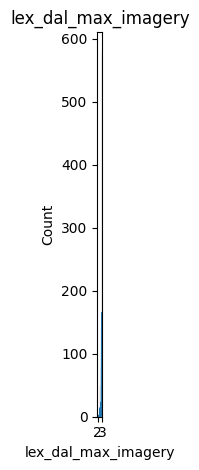

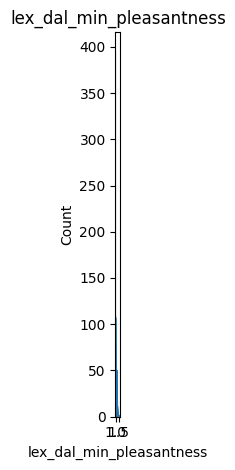

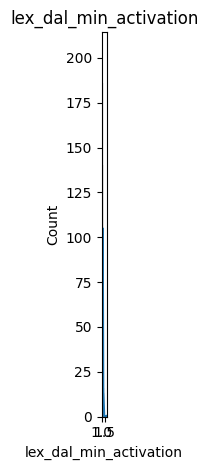

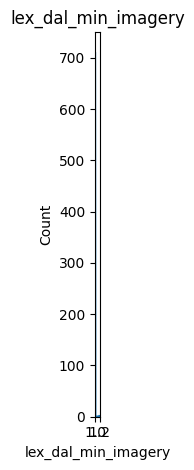

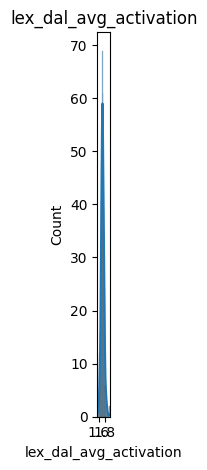

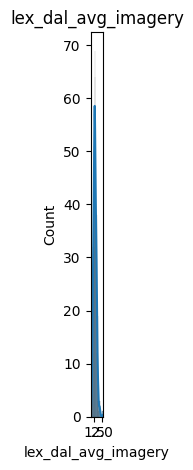

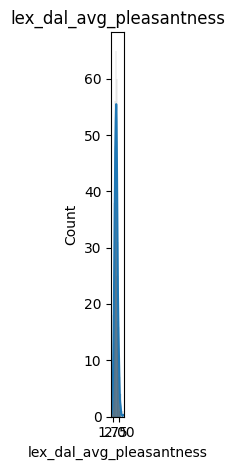

In [59]:
dal_cols = [c for c in eda_df.columns if c.startswith('lex_dal_')]
print('DAL columns found:', dal_cols)
if dal_cols:
    plt.figure(figsize=(8,4))
    for i,c in enumerate(dal_cols):
        plt.subplot(1,len(dal_cols),i+1)
        sns.histplot(eda_df[c].dropna(), bins=40, kde=True)
        plt.title(c)
        plt.tight_layout()
        plt.show()

In [60]:
# 9. Sentiment distribution

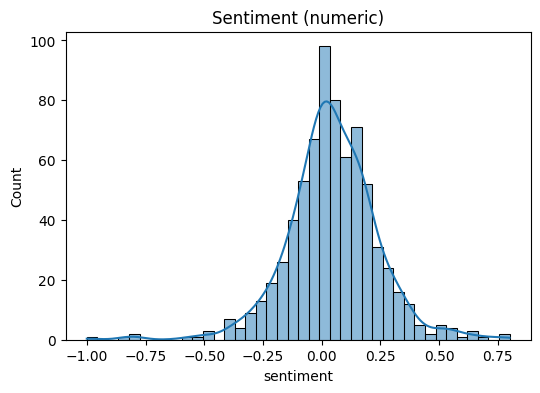

In [62]:
if 'sentiment' in eda_df.columns:
    plt.figure(figsize=(6,4))
    if pd.api.types.is_numeric_dtype(eda_df['sentiment']):
        sns.histplot(eda_df['sentiment'].dropna(), bins=40, kde=True)
        plt.title('Sentiment (numeric)')
    else:
        sns.countplot(x='sentiment', data=eda_df)
        plt.title('Sentiment (categorical)')
        plt.tight_layout()
        plt.show()
        plt.savefig(OUT_DIR/'sentiment_distribution.png')
        plt.close()

syntax cols: ['syntax_ari', 'syntax_fk_grade']


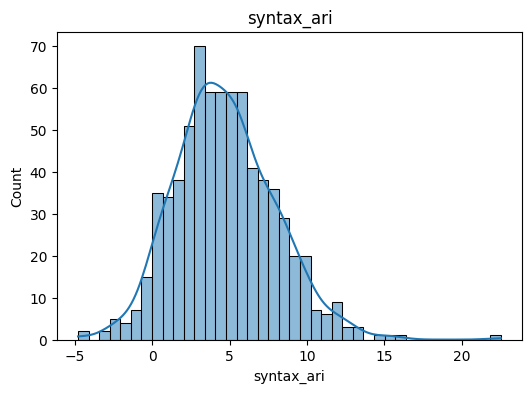

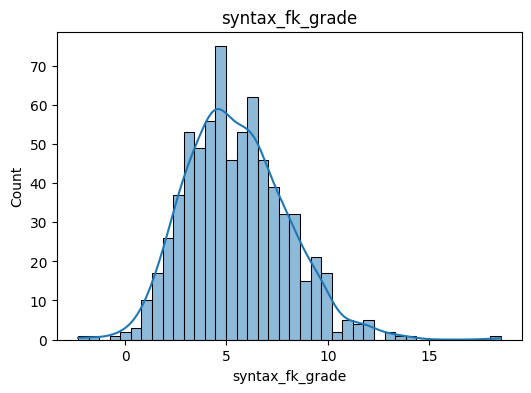

In [63]:
# 10. Syntax complexity distribution (syntax_ari, syntax_fk_grade)
syntax_cols = [c for c in eda_df.columns if c.startswith('syntax_') or c=='syntax_fk_grade' or c=='syntax_ari']
print('syntax cols:', syntax_cols)


for c in syntax_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(eda_df[c].dropna(), bins=40, kde=True)
    plt.title(c)
    plt.tight_layout
    plt.show()
    plt.savefig(OUT_DIR/f'{c}_dist.png')
    plt.close()

social cols: ['social_timestamp', 'social_karma', 'social_upvote_ratio', 'social_num_comments']


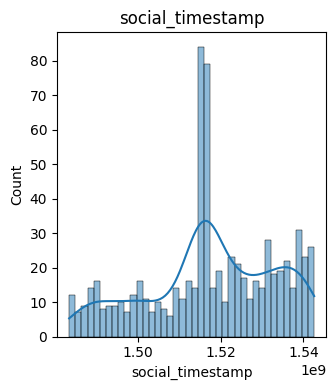

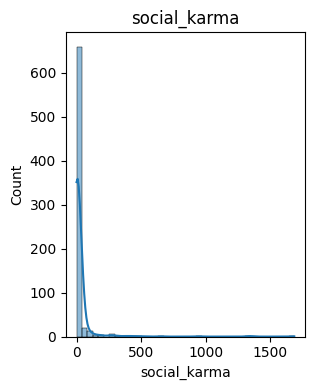

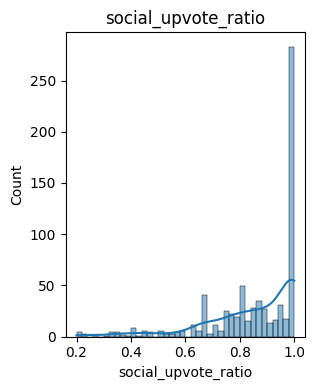

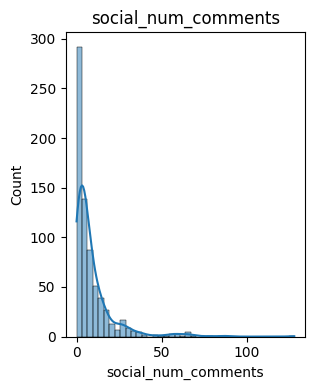

In [65]:
# 11. Social metadata overview (social_karma, social_upvote_ratio, social_num_comments)
social_cols = [c for c in eda_df.columns if c.startswith('social_')]
print('social cols:', social_cols)


if social_cols:
    eda_df[social_cols].describe()
    eda_df[social_cols].describe().to_csv(OUT_DIR/'social_summary.csv')
    
    for i,c in enumerate(social_cols):
        plt.figure(figsize=(12,4))
        plt.subplot(1,len(social_cols),i+1)
        sns.histplot(eda_df[c].dropna(), bins=40, kde=True)
        plt.title(c)
        plt.tight_layout()
        plt.show()
        plt.savefig(OUT_DIR/'social_distributions.png')
        plt.close()

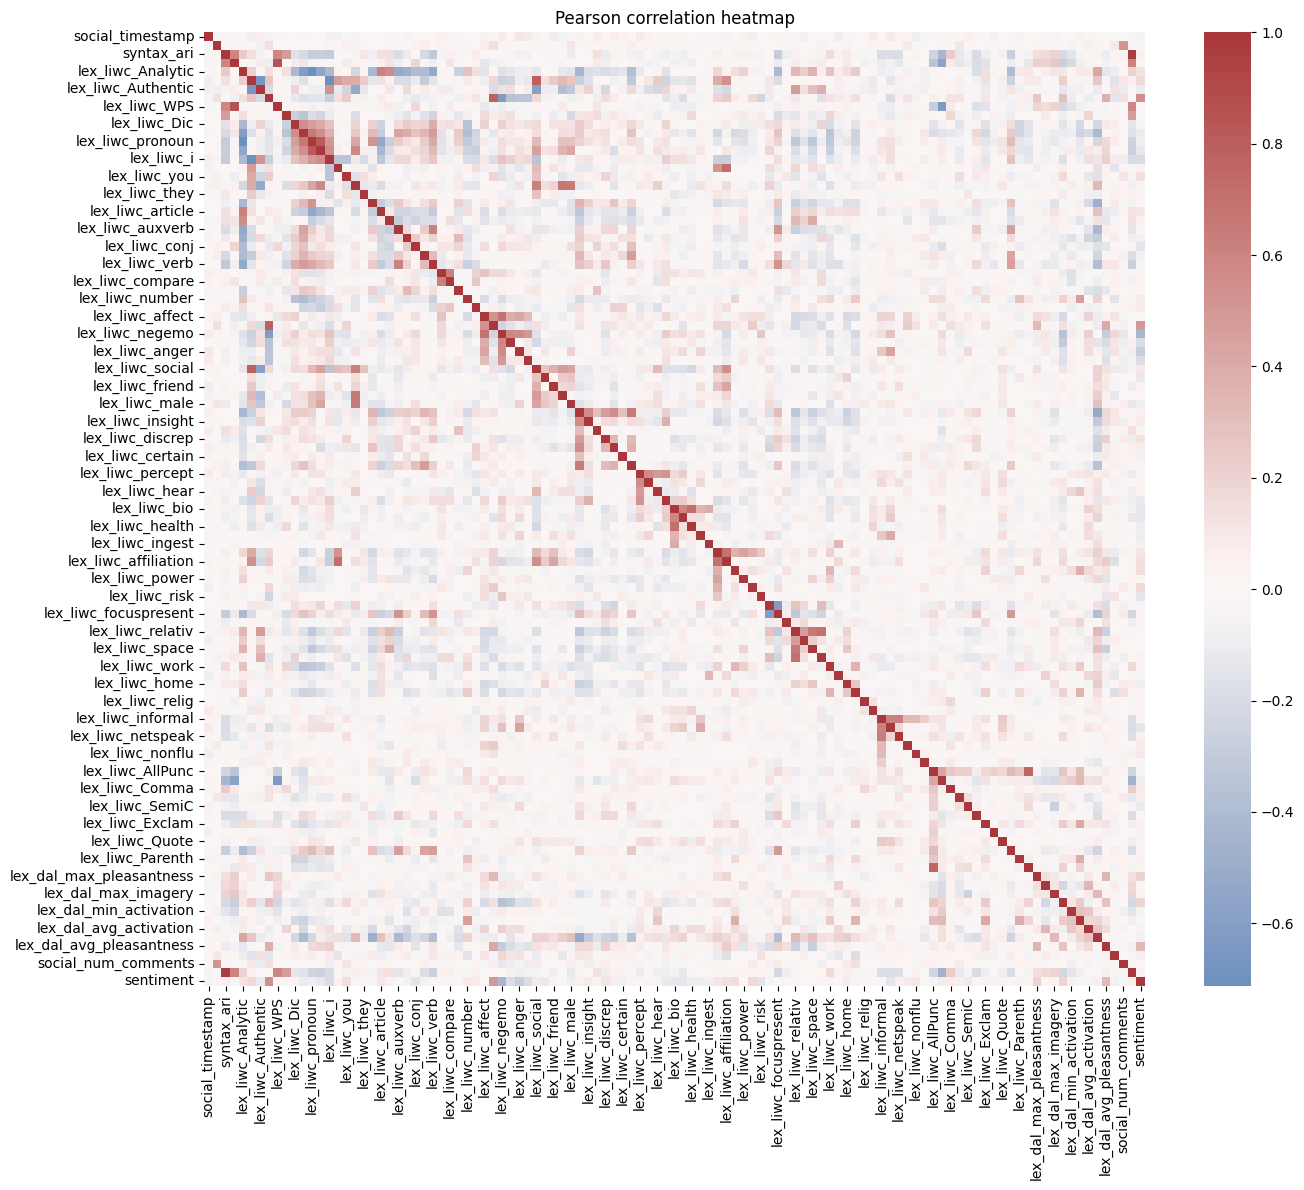

In [66]:
# 12. Correlation heatmap of lexical/psycholinguistic features
# Choose numeric columns for correlation
corr_cols = [c for c in eda_df.columns if (
c.startswith('lex_liwc_') or c.startswith('lex_dal_') or c.startswith('syntax_') or c in ['sentiment'] or c.startswith('social_')
) and pd.api.types.is_numeric_dtype(eda_df[c])]


corr_df = eda_df[corr_cols].dropna()
pearson_corr = corr_df.corr(method='pearson')
spearman_corr = corr_df.corr(method='spearman')


plt.figure(figsize=(14,12))
sns.heatmap(pearson_corr, cmap='vlag', center=0)
plt.title('Pearson correlation heatmap')
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR/'pearson_correlation_heatmap.png')
plt.close()


plt.figure(figsize=(14,12))
sns.heatmap(spearman_corr, cmap='vlag', center=0)
plt.title('Spearman correlation heatmap')
plt.tight_layout()
plt.show
plt.savefig(OUT_DIR/'spearman_correlation_heatmap.png')
plt.close()

pearson_corr
spearman_corr

# Save correlation CSVs
pearson_corr.to_csv(OUT_DIR/'pearson_corr.csv')
spearman_corr.to_csv(OUT_DIR/'spearman_corr.csv')

In [68]:
# 13. Inspect sample posts from each class
sample_by_class = eda_df.groupby('label')['text'].apply(lambda s: s.sample(n=min(10,len(s)), random_state=42)).reset_index()
sample_by_class.to_csv(OUT_DIR/'sample_posts_by_class.csv', index=False)


# Print first few
for lbl, group in eda_df.groupby('label'):
    print(f"\nLabel: {lbl} - sample posts ({min(5,len(group))}):")
    print(group['text'].astype(str).head(5).to_list())


Label: 0 - sample posts (5):
['Its like that, if you want or not.“ ME: I have no problem, if it takes longer. But you asked my friend for help and let him wait for one hour and then you haven’t prepared anything. Thats not what you asked for. Instead of 3 hours, he helped you for 10 hours till 5am...', 'I man the front desk and my title is HR Customer Service Representative. About 50% of my job is spent onboarding new hires. Maybe 10% is clerical/paperwork. The rest is dealing with people who walk in and need help with benefits, retirement, etc. Although I am required to know the basics of our benefits plans and how the retirement and pension benefits work, many employees have questions beyond my knowledge base.', 'I haven’t said anything to him yet because I’m not sure how someone would take hearing that their partner has such fluctuations of feelings towards them (especially since he told me he loves me and is somewhat clingy). Nonetheless, I know a conversation will need to be had 

In [69]:
# 14. Identify potential noise, outliers, low-confidence labels
# Low-confidence labels (example threshold)
if 'confidence' in eda_df.columns:
    low_conf = eda_df[eda_df['confidence'] < 0.6]
    low_conf.to_csv(OUT_DIR/'low_confidence_labels.csv', index=False)
    print('\nLow-confidence count:', low_conf.shape[0])


# Outliers by text length (IQR method)
q1 = eda_df['token_len'].quantile(0.25)
q3 = eda_df['token_len'].quantile(0.75)
irq = q3 - q1
outliers_len = eda_df[(eda_df['token_len'] < (q1 - 1.5*irq)) | (eda_df['token_len'] > (q3 + 1.5*irq))]
print(outliers_len)
outliers_len.to_csv(OUT_DIR/'outliers_by_length.csv', index=False)


# Unusually high/low social_karma
if 'social_karma' in eda_df.columns:
    s_q1 = eda_df['social_karma'].quantile(0.01)
    s_q99 = eda_df['social_karma'].quantile(0.99)
    top_karma = eda_df[eda_df['social_karma'] > s_q99]
    low_karma = eda_df[eda_df['social_karma'] < s_q1]
    print(pd.concat([top_karma, low_karma]))
    pd.concat([top_karma, low_karma]).to_csv(OUT_DIR/'extreme_social_karma.csv', index=False)


# Potential label disagreements: look for posts with extreme lexical-sentiment mismatch (optional heuristic)
# e.g., high positive sentiment but labeled 'stress' or vice versa
if 'sentiment' in eda_df.columns and pd.api.types.is_numeric_dtype(eda_df['sentiment']):
    suspicious = eda_df[((eda_df['sentiment'] > eda_df['sentiment'].quantile(0.75)) & (eda_df['label']=='stress')) | ((eda_df['sentiment'] < eda_df['sentiment'].quantile(0.25)) & (eda_df['label']=='non-stress'))]
    print(suspicious)
    suspicious.to_csv(OUT_DIR/'suspicious_sentiment_label_mismatch.csv', index=False)


Low-confidence count: 115
                                                  text  label  \
59   My girlfriend and I have been amazingly strong...      0   
84   Okay this is driving totally insane and I can'...      1   
112  Spring 2102 I began to see a man that I worked...      0   
124  I'd never heard this idea until recently, and ...      0   
148  I dwell on negativity quite easily and am I ea...      0   
156  I don't get anxious over things that I know wo...      1   
179  I get that three mistakes in a row is nothing ...      1   
193  I am called back as a few secondary characters...      1   
267  No history of DV, married 8 years, together 10...      1   
291  Almost too well. She extends our date twice, b...      1   
323  in the end i just end up leaving, ignoring the...      1   
360  I'm afraid that I could also give her those sn...      1   
372  I'll call him out on his behavior or try to st...      1   
429  I am unsure how to begin, but brief about me. ...      0  

In [70]:
# 15. Save cleaned numeric matrix for modeling (optional)
numeric_cols = [c for c in corr_cols]
numeric_cols += ['token_len','char_len']


X_numeric = eda_df[numeric_cols].copy()
print(X_numeric)
X_numeric.to_csv(OUT_DIR/'numeric_matrix_for_modeling.csv', index=False)

     social_timestamp  social_karma  syntax_ari  lex_liwc_WC  \
0          1514980773            22   -1.238793           55   
1          1493348050             5    7.684583           72   
2          1524516630            10    2.360408          148   
3          1524018289             5    5.997000          100   
4          1516200171           138    4.649418           78   
..                ...           ...         ...          ...   
710        1517790160             7    4.597368           53   
711        1515192055             0    1.452083           72   
712        1516848555             3    3.956447           71   
713        1532048310            18    0.236814           60   
714        1517604595             4    3.221250           62   

     lex_liwc_Analytic  lex_liwc_Clout  lex_liwc_Authentic  lex_liwc_Tone  \
0                 2.82           57.22               55.41           5.95   
1                64.56           50.00               31.19          92.40   


In [71]:
# 16. Final report summary (text file)
with open(OUT_DIR/'eda_report_summary.txt','w', encoding='utf-8') as f:
    f.write('Dreaddit EDA summary\n')
    f.write('---------------------\n')
    f.write(f"Rows, cols: {eda_df.shape}\n")
    f.write('\nClass distribution:\n')
    f.write(class_counts.to_string())
    f.write('\n\nText length (tokens) summary:\n')
    f.write(eda_df['token_len'].describe().to_string())
    f.write('\n\nTop 10 LIWC features by variance:\n')
    if liwc_cols:
        var = eda_df[liwc_cols].var().sort_values(ascending=False).head(10)
        f.write(var.to_string())


print('\nEDA complete. Outputs saved to', OUT_DIR.resolve())


EDA complete. Outputs saved to C:\Users\AYUSH SINGH\Documents\GitHub\NervSightX\Machine learning\dreaddit_eda_outputs
